In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
conn = psycopg2.connect(host="localhost",database="mimic", user="postgres", password='postgres', port = '5432')
#cur = conn.cursor()

In [5]:
sql = """select subject_id, count(distinct echo_charttime) as echo_tests
from mimiciii.echo_summary_single_icu_stay
group by subject_id"""
df = pd.read_sql_query(sql, conn)

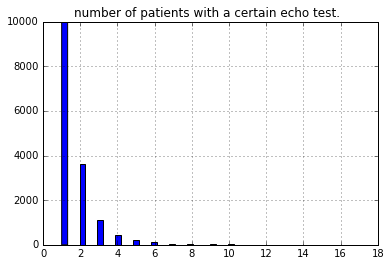

In [6]:
axes = df.echo_tests.hist(bins = 50)
axes.set_title('number of patients with a certain echo test.  ')

In [136]:
sql = """
SELECT subject_id, hadm_id, icustay_id, intime, outtime, los_icu, angus, 
       echo_charttime, indication, test, doppler, infection, explicit_sepsis, 
       organ_dysfunction, mech_vent, (echo_charttime - intime) as echotime_wrt_intime, 
       (echo_charttime - outtime) as echotime_wrt_outtime
  FROM mimiciii.echo_summary_single_icu_stay"""
df = pd.read_sql_query(sql, conn)

In [137]:
df.echotime_wrt_intime_hours = df.echotime_wrt_intime.astype('timedelta64[h]')
df.echotime_wrt_outtime_hours = df.echotime_wrt_outtime.astype('timedelta64[h]')
df.echotime_wrt_intime_days = df.echotime_wrt_intime.astype('timedelta64[D]')
df.echotime_wrt_outtime_days = df.echotime_wrt_outtime.astype('timedelta64[D]')

In [138]:
print "Number of subjects with echo within 5 days before ICU stay: ", df.subject_id[(df.echotime_wrt_intime_hours<0) & (df.echotime_wrt_intime_hours>-5*24)].count()
print "Number of subjects with echo within first 48 hours of ICU: ", df.subject_id[(df.echotime_wrt_intime_hours>=0) & (df.echotime_wrt_intime_hours<48)].count()
print "Number of subjects with echo after ICU: ", df.subject_id[(df.echotime_wrt_outtime_hours>0)].count()

Number of subjects with echo within 5 days before ICU stay:  4080
Number of subjects with echo within first 48 hours of ICU:  9765
Number of subjects with echo after ICU:  6488


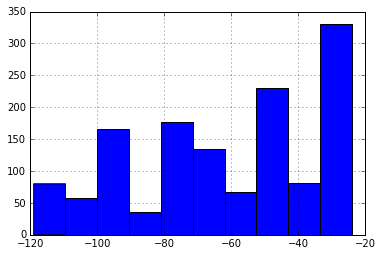

In [139]:
df.echotime_wrt_intime_hours[(df.echotime_wrt_intime_hours<-23) & (df.echotime_wrt_intime_hours>-5*24)].hist()

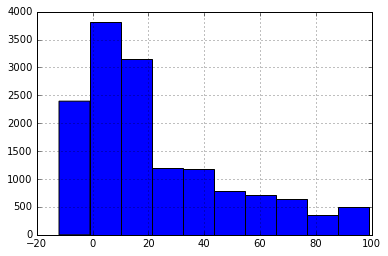

In [140]:
df.echotime_wrt_intime_hours[(df.echotime_wrt_intime_hours>=-12) & (df.echotime_wrt_intime_hours<100)].hist()

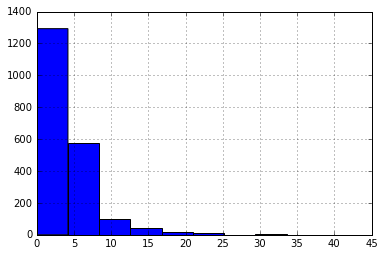

In [141]:
df.echotime_wrt_intime_days[(df.echotime_wrt_outtime_hours>=12) & (df.echotime_wrt_outtime_days<=5)].hist()

In [145]:
print "Number of sepsis subjects with echo within 5 days before ICU stay: "
print df.subject_id[(df.explicit_sepsis == 1) & (df.echotime_wrt_intime_days<-5) & (df.echotime_wrt_intime_days>-30)].count()
print "Number of sepsis subjects with echo within first 48 hours of ICU: "
print df.subject_id[(df.explicit_sepsis == 1) & (df.echotime_wrt_intime_hours>=0) & (df.echotime_wrt_intime_hours<48)].count()
print "Number of sepsis subjects with echo after ICU: "
print df.subject_id[(df.explicit_sepsis == 1) & (df.echotime_wrt_outtime_hours>0)].count()

Number of sepsis subjects with echo within 5 days before ICU stay: 
118
Number of sepsis subjects with echo within first 48 hours of ICU: 
870
Number of sepsis subjects with echo after ICU: 
313


## Admission diagnosis

In [149]:
sql = """
SELECT a.subject_id, a.hadm_id, e.icustay_id, a.diagnosis
  FROM mimiciii.echo_summary_single_icu_stay as e
  join mimiciii.admissions as a
  on e.subject_id = a.subject_id
  where explicit_sepsis = 1"""
df = pd.read_sql_query(sql, conn)

## Comorbidities

In [156]:
sql = """SELECT e.subject_id, e.hadm_id, e.icustay_id, c.congestive_heart_failure, c.cardiac_arrhythmias, c.valvular_disease,
  c.renal_failure
  FROM mimiciii.echo_summary_single_icu_stay as e
  inner join mimiciii.elixhauser_ahrq as c
  on e.subject_id = c.subject_id
  inner join mimiciii.angus_sepsis as s
  on e.subject_id = s.subject_id
  where s.explicit_sepsis = 1"""
df = pd.read_sql_query(sql, conn)

In [157]:
print 'Patients with echo, sepsis, and their commorbidities'
df.head(10)


Patients with echo, sepsis, and their commorbidities


,subject_id,hadm_id,icustay_id,congestive_heart_failure,cardiac_arrhythmias,valvular_disease,renal_failure
0,23507,100253.0,218342,1,0,0,0
1,23507,NaN,218342,1,0,0,0
2,652,100262.0,271918,1,0,0,0
3,652,100262.0,271918,1,0,0,0
4,652,100262.0,271918,1,0,0,0
5,652,100262.0,271918,1,0,0,0
6,652,100262.0,271918,1,0,0,0
7,10056,100375.0,285789,1,0,0,0
8,8475,100379.0,253002,1,0,0,0
9,8475,100379.0,253002,1,0,0,0


In [169]:
df.subject_id[df.congestive_heart_failure ==1]

AttributeError: 'DataFrame' object has no attribute 'subject_id'

In [166]:
# getting codes for BNP
sql = """
SELECT row_id, itemid, label, abbreviation, dbsource, linksto, category, 
       unitname, param_type, conceptid
  FROM mimiciii.d_items
  where label like '%BNP%' or label like '%Troponin%'
  order by label;
"""
df = pd.read_sql_query(sql, conn)

In [167]:
df.head()

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,4600,7294,BNP,None,carevue,chartevents,None,None,None,None
1,14760,227446,Brain Natiuretic Peptide (BNP),Brain Natiuretic Peptide (BNP),metavision,chartevents,Labs,None,Numeric with tag,None
2,1139,851,Troponin,None,carevue,chartevents,Enzymes,None,None,None
3,14751,227429,Troponin-T,Troponin-T,metavision,chartevents,Labs,None,Numeric with tag,None
4,14079,225622,ZBrain Natiuretic Peptide (BNP),ZBrain Natiuretic Peptide (BNP),metavision,chartevents,Labs,None,Numeric,None
